# Functional connectivity within subjects


<img src="http://drive.google.com/uc?export=view&id=1GPJ8XWcvqHr9NnyVm2DubagzV7cBPvsR" style="height:250px"/>

- The correlation of the time course of activity from the seed voxel with the time series from the target voxel is a proxy for the functional connectivity between those areas. 
- We have strong hypotheses about how information should flow in the brain. So instead of doing these analyses for the whole brain we do them for specific regions (`==ROI==pairs of voxels`).
- BOLD signal is noisy, remove noise and correct for movement $\rightarrow$ residuals. We do this analysis with the residuals, which is a proxy for the actual BOLD signal. 


See the [brainiak connectivity tutortial - 08](https://brainiak.org/tutorials/08-connectivity/) for more info.

In [1]:
import warnings
import h5py
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn import input_data

from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nibabel.affines import apply_affine
import nibabel as nib
import time

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats
from numpy.linalg import inv

# import own functions
import utils
reload(utils)

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

# 1. Load masks, residuals & specify params 

- Only take the residuals `'R'`, omit the rest of the variables.
- Save residuals as `.npy` files so that we can throw away the large files

In [2]:
path = '/Users/Daphne/data/'

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii.affine) # get the transformation matrix

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows


# residuals
R = np.load(path+'residuals_sub1.npy')

In [3]:
## uncomment and do for all subjects
# path = '/Users/Daphne/data/'
# filename = 'residuals_glm9_subj1_smooth.mat'

# data = h5py.File(path+filename,'r') 

# print(data.keys())
# print(data['R'].value.shape)

# residuals_sub1 = data['R'].value # store residuals for subject

# np.save('residuals_sub1', residuals_sub1)

In [4]:
R.shape

(220075, 1698)

In [5]:
R = np.swapaxes(R,1,0)

R.shape # TRs x voxels

(1698, 220075)

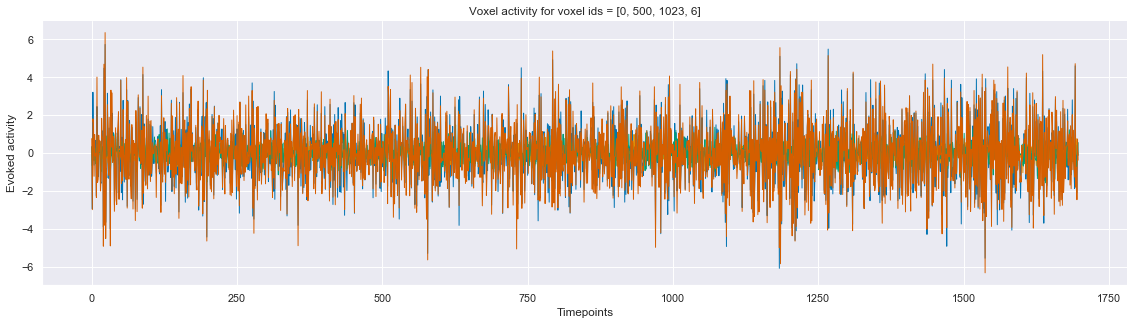

In [6]:
"""
Plot the timeseries for a few voxels
"""
voxel_ids = [0, 500, 1023, 6]

plt.figure(figsize=(20, 5), dpi=70)
plt.title(f'Voxel activity for voxel ids = {voxel_ids}');
plt.plot(R[:, voxel_ids], linewidth=1);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');
sns.despine()

# 2. Create a seed

- We loaded the whole-brain residuals
- Now, we create seed ROIs and correlate their activity with other voxels in the brain
- If we find voxels that are correlated with a seed ROI, this suggests that these voxels are functionally connected

### How to choose the seed voxels

1. Use momchils voxels
2. Use the voxels found with my own analysis (see `find_ROIs.ipynb`)


## 2.1 Create a spherical ROI with a seed voxel

[NiftiSpheresMasker](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiSpheresMasker.html)

In [16]:
# theory ROIs (model-based) 
# all MNI coordinates!
R_IFG_Tri = [42, 28, 26]
L_Insula = [-30, 28, 2]
R_DMPFC = [6, 38, 40]
L_IFG_Tri = [-50, 44, 12]
L_MTG = [-64, -50, 4]
R_MTG = [58, -36, 8]

# control voxel
# tip: can always try the contralateral ROIs: [-x y z]
L_lingual = [2, -86, 4]
Occipital = [-36 -88 -12]

In [17]:
# === CHOOSE COORDINATES === (must be MNI)
coords_ROI = R_IFG_Tri
# ==========================

# Init the masking object
masker_ROI = input_data.NiftiSpheresMasker(
    coords_ROI, 
    radius=8, standardize=True, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0
)

## 2.2 Plot the signal for the mask

The average bold signal for all the voxels in the mask is computed and plotted.

In [18]:
hdr = mask_nii.get_header()
hdr.get_xyzt_units() # voxel size & time units

('mm', 'sec')

# 3. Compute the correlation matrix

- In seed analysis we compute the cross correlation between the time series of the seed voxel and all other voxels.
- 


```Python
For all voxels in whole brain mask

    correlate with seed voxel
```

### Caveats

- May have different hemodynamic lags in different regions



In [19]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
num_voxels = R.shape[0]
all_corr = np.zeros((num_voxels, 1))

all_corr.shape

# get the corresponding voxel
native_coords = apply_affine(aff=inv_affine, pts=coords_ROI) # from mni2cor
top_vox = utils.get_vox_from_coords(coords_mat, native_coords) # corresponding voxel

The coordinates correspond to voxel: 146217.


In [11]:
R.shape[0]

1698

In [12]:
R.shape

(1698, 220075)

In [13]:
np.corrcoef(R[:,3], R[:,top_vox])[0,1] 

-0.06976352078946875

In [14]:
for v in range(num_voxels): 
    all_corr[v, 0] = np.corrcoef(R[:,v], R[:,top_vox])[0,1] # take one value 

end_time = time.time()

print('Analysis duration for %d voxels: %0.2fs' % (num_voxels, (end_time - start_time)))

Analysis duration for 1698 voxels: 1.72s


In [15]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
num_voxels = bold_wb_r.shape[1]
all_corr = np.zeros((num_voxels, 1))
for v in range(num_voxels): 
    all_corr[v, 0] = np.corrcoef(bold_lPPA_r.flatten(), bold_wb_r[:, v])[0, 1]

end_time = time.time()
print('Analysis duration for %d voxels: %0.2fs' % (num_voxels, (end_time - start_time)))

NameError: name 'bold_wb_r' is not defined

In [ ]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
num_voxels = bold_wb_r.shape[1]
all_corr = np.zeros((num_voxels, 1))
for v in range(num_voxels): 
    all_corr[v, 0] = np.corrcoef(bold_lPPA_r.flatten(), bold_wb_r[:, v])[0, 1]

end_time = time.time()
print('Analysis duration for %d voxels: %0.2fs' % (num_voxels, (end_time - start_time)))

# 4. 

In [ ]:
oxel
threshold = .8

# Nilearn has useful tools for plotting our results as a map
r_map_ar = plotting.plot_stat_map(
    img_corr_lPPA_r, 
    threshold=threshold,
    cut_coords=coords_lPPA[0],
)
# Add the seed
r_map_ar.add_markers(
    marker_coords=coords_lPPA, 
    marker_color='g',
    marker_size=50
)